In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import klib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.cluster import KMeans
import optuna
from datetime import datetime
import os
import logging
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [61]:
# Setup logging configuration
log_filename = 'model_training.log'
logging.basicConfig(
    filename=log_filename,
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [62]:
train_df = pd.read_csv(r"C:\Users\paulo\OneDrive\Documents\kaggle_competition_2_datasets\train.csv", index_col='id')

In [63]:
# Separate features and target variable
X = train_df.drop('Response', axis=1)
y = train_df['Response']

# Determine sample size (10% of the dataset)
sample_size = 0.4

# Stratified sampling
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size, random_state=42, stratify=y)

# Combine sampled features and target variable
train_df = pd.concat([X_sample, y_sample], axis=1)

In [64]:
# Preprocess data
def preprocess_data(df):
    # Transform binary variables
    df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
    df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes': 1, 'No': 0})
    
    # Ordinal Encoding for Vehicle_Age
    vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
    df['Vehicle_Age'] = df['Vehicle_Age'].map(vehicle_age_mapping)
    
    # Drop Driving_License due to limited variability
    df.drop(['Driving_License'], axis=1, inplace=True)
    
    return df

train_data = preprocess_data(train_df)

In [65]:
# Remove outliers from Annual_Premium in training data only
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

train_df = remove_outliers_iqr(train_df, 'Annual_Premium')

In [66]:
def feature_engineering(df):
    df = df.copy()  # Create a copy to avoid the warning
    df['Previously_Insured_Annual_Premium'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Annual_Premium'].astype(str)))[0]
    df['Previously_Insured_Vehicle_Age'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Vehicle_Age'].astype(str)))[0]
    df['Previously_Insured_Vehicle_Damage'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Vehicle_Damage'].astype(str)))[0]
    df['Previously_Insured_Vintage'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Vintage'].astype(str)))[0]
    
    # New interaction features
    df['Annual_Premium_Vehicle_Age'] = pd.factorize((df['Annual_Premium'].astype(str) + df['Vehicle_Age'].astype(str)))[0]
    df['Annual_Premium_Vintage'] = pd.factorize((df['Annual_Premium'].astype(str) + df['Vintage'].astype(str)))[0]
    df['Age_Vehicle_Damage'] = pd.factorize((df['Age'].astype(str) + df['Vehicle_Damage'].astype(str)))[0]
    df['Age_Vintage'] = pd.factorize((df['Age'].astype(str) + df['Vintage'].astype(str)))[0]

    return df

train_df = feature_engineering(train_df)

In [67]:
# Separate features and target variable
X = train_df.drop('Response', axis=1)
y = train_df['Response'] 

In [68]:
scaler = StandardScaler()
train_df =  scaler.fit_transform(X)

In [69]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [70]:
param = {
    'objective': 'binary',
    'metric': 'auc',
    'lambda_l1': 0.02,  
    'lambda_l2': 0.1,  
    'colsample_bytree': 0.75, 
    'subsample': 0.85, 
    'learning_rate':  0.09,  
    'max_depth': 32, 
    'num_leaves': 900, 
    'min_child_samples': 50,  
    'min_child_weight': 9.0,  
    'min_split_gain': 0.09,  
    'max_bin': 420,
    'scale_pos_weight': 10,
    'early_stopping_round': 100,
    'n_jobs': 8,
    }

num_boost_round = 20000

# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
# Train model
bst = lgb.train(
    param,
    train_data, 
    valid_sets=[valid_data],
    num_boost_round=num_boost_round,
    )
    
# Predict and evaluate
y_val_pred = bst.predict(X_val, num_iteration=bst.best_iteration)
auc = roc_auc_score(y_val, y_val_pred)

# Make predictions
y_train_pred_proba = bst.predict(X_train, num_iteration=bst.best_iteration)
y_val_pred_proba = bst.predict(X_val, num_iteration=bst.best_iteration)

# Calculate ROC AUC scores
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)
roc_auc_val = roc_auc_score(y_val, y_val_pred_proba)

# Print ROC AUC scores
print(f'Training ROC AUC Score: {roc_auc_train}')
print(f'Validation ROC AUC Score: {roc_auc_val}')

# Log ROC AUC scores
logging.info(f'Training ROC AUC Score: {roc_auc_train}')
logging.info(f'outliers only custom Validation ROC AUC Score: {roc_auc_val}')

[LightGBM] [Info] Number of positive: 353132, number of negative: 2567590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3159
[LightGBM] [Info] Number of data points in the train set: 2920722, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120906 -> initscore=-1.983881
[LightGBM] [Info] Start training from score -1.983881
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[134]	valid_0's auc: 0.89025
Training ROC AUC Score: 0.9164635099895243
Validation ROC AUC Score: 0.8902498390814235


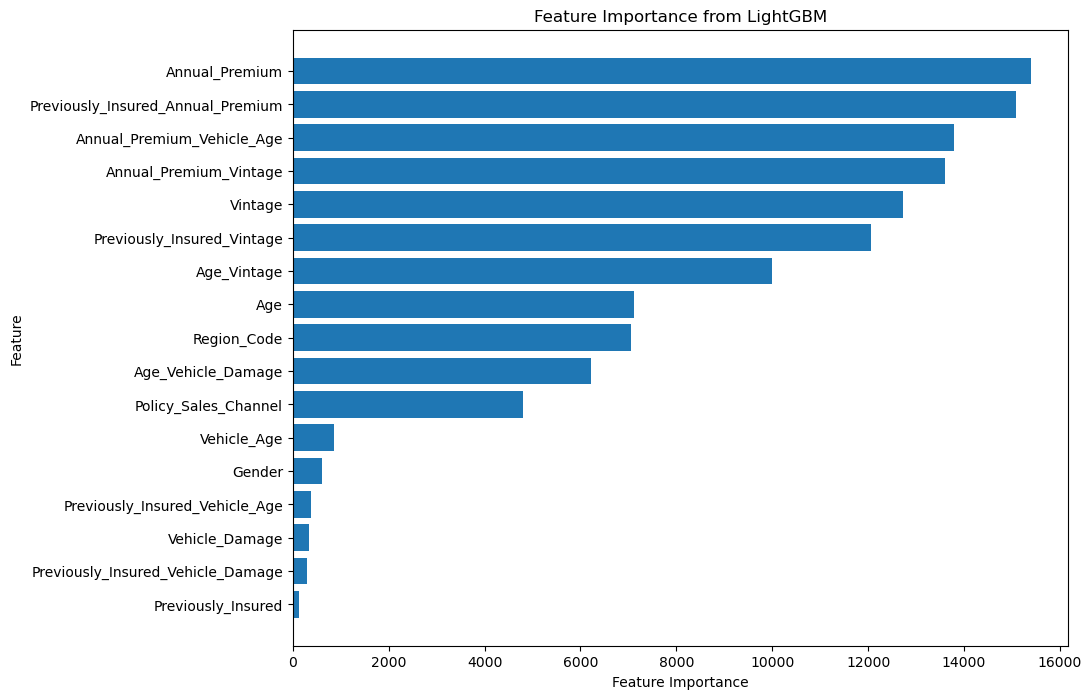

                              Feature  Importance
6                      Annual_Premium       15394
9   Previously_Insured_Annual_Premium       15091
13         Annual_Premium_Vehicle_Age       13784
14             Annual_Premium_Vintage       13607
8                             Vintage       12727
12         Previously_Insured_Vintage       12055
16                        Age_Vintage        9996
1                                 Age        7111
2                         Region_Code        7064
15                 Age_Vehicle_Damage        6222
7                Policy_Sales_Channel        4793
4                         Vehicle_Age         860
0                              Gender         615
10     Previously_Insured_Vehicle_Age         384
5                      Vehicle_Damage         335
11  Previously_Insured_Vehicle_Damage         299
3                  Previously_Insured         129


In [71]:
# Get feature importance
importance = bst.feature_importance()
feature_names = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from LightGBM')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

# Print feature importance
print(importance_df)

In [72]:
# import optuna
# import lightgbm as lgb
# from sklearn.metrics import roc_auc_score
# from sklearn.model_selection import train_test_split
# from datetime import datetime
# import os

# def objective(trial):
#     param = {
#         'objective': 'binary',
#         'metric': 'auc',
#         'lambda_l1': trial.suggest_float('reg_alpha', 0.01, 0.1, log=True),  
#         'lambda_l2': trial.suggest_float('reg_lambda', 0.1, 0.3, log=True),  
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.75, 0.85), 
#         'subsample': trial.suggest_float('subsample', 0.85, 1.0), 
#         'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),  
#         'max_depth': trial.suggest_int('max_depth', 16, 32), 
#         'num_leaves': trial.suggest_int('num_leaves', 700, 1500), 
#         'min_child_samples': trial.suggest_int('min_child_samples', 20, 80),  
#         'min_child_weight': trial.suggest_float('min_child_weight', 4.0, 10.0),  
#         'min_split_gain': trial.suggest_float('min_split_gain', 0.05, 0.1),  
#         'max_bin': trial.suggest_int('max_bin', 400, 500),
#         'verbose': -1,  
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 9, 12),
#         'early_stopping_round': 100,
#     }

#     num_boost_round = trial.suggest_int('num_boost_round', 10000, 20000)

#     # Create LightGBM dataset
#     train_data = lgb.Dataset(X_train, label=y_train)
#     valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
#     # Train model
#     bst = lgb.train(
#         param,
#         train_data, 
#         num_boost_round=num_boost_round,
#         valid_sets=[valid_data],
#     )
    
#     # Predict and evaluate
#     y_val_pred = bst.predict(X_val, num_iteration=bst.best_iteration)
#     auc = roc_auc_score(y_val, y_val_pred)
#     return auc

# # Generate a unique filename for each run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# sqlite_file_path = os.path.join(r'C:\Users\paulo\OneDrive\Documents\Binary-Classification-of-Insurance-Cross-Selling', f'optuna_study_{timestamp}.db')

# # Create a study and optimize
# study = optuna.create_study(storage=f'sqlite:///{sqlite_file_path}', study_name=f'my_study_{timestamp}', direction='maximize')
# study.optimize(objective, n_trials=10)

# # Get the best trial
# best_trial = study.best_trial
# print(f'Best trial score: {best_trial.value}')
# print(f'Best trial params: {best_trial.params}')

